In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches': 'tight'}
import cv2 as cv
import numpy as np
import scipy as sp
import scipy.stats
import math as m
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 96
mpl.rcParams['figure.dpi'] = 96
import matplotlib.pyplot as plt
from omrtemplate import get_template_rois
from pyzbar.pyzbar import decode
from pdf2image import convert_from_path
import os
import shutil
import fitz

In [119]:
SHOW_PROCESSING_STEPS = True
FIGSIZE=(15.5, 23)
#FIGSIZE=(5, 8)
CONTOUR_EPS = 0.02
COMPACTNESS_EPS = 0.1
AREA_EPS = 0.7
CLOSENESS_EPS = 1.5
CLAHE_CLIPLIMIT = 4.0
FIRST_BLUR_KSIZE = 3
SECOND_BLUR_KSIZE = 3
SKIP_FIRST_ADAPTIVE_THRESH = True
SKIP_SECOND_ADAPTIVE_THRESH = True
FIRST_THRESH_BLOCK_SIZE = 33
SECOND_THRESH_BLOCK_SIZE = 33
THRESH_BIAS = 3
LAPLACE_KSIZE = 5
TEMPLATE_PATH = 'formular-raspunsuri.svg'
SCAN_PATH = 'samples/photoaf3.jpg'
PDF_SCANS_PATH = '/home/acracan/Documents/scoala/dce_eth/examene 2018-2018/rezultate/colocviu_2019_01_17_66_teze.pdf'

In [29]:
pdf_scans = fitz.open(PDF_SCANS_PATH)
pdf_image_refs = []
for p in range(len(pdf_scans)):
    pdf_image_refs += [obj[0] for obj in pdf_scans.getPageImageList(p)]

def fitz_to_cv(doc, ref):
    return cv.imdecode(np.frombuffer(doc.extractImage(ref)['image'], dtype=np.uint8),
                       cv.IMREAD_COLOR)

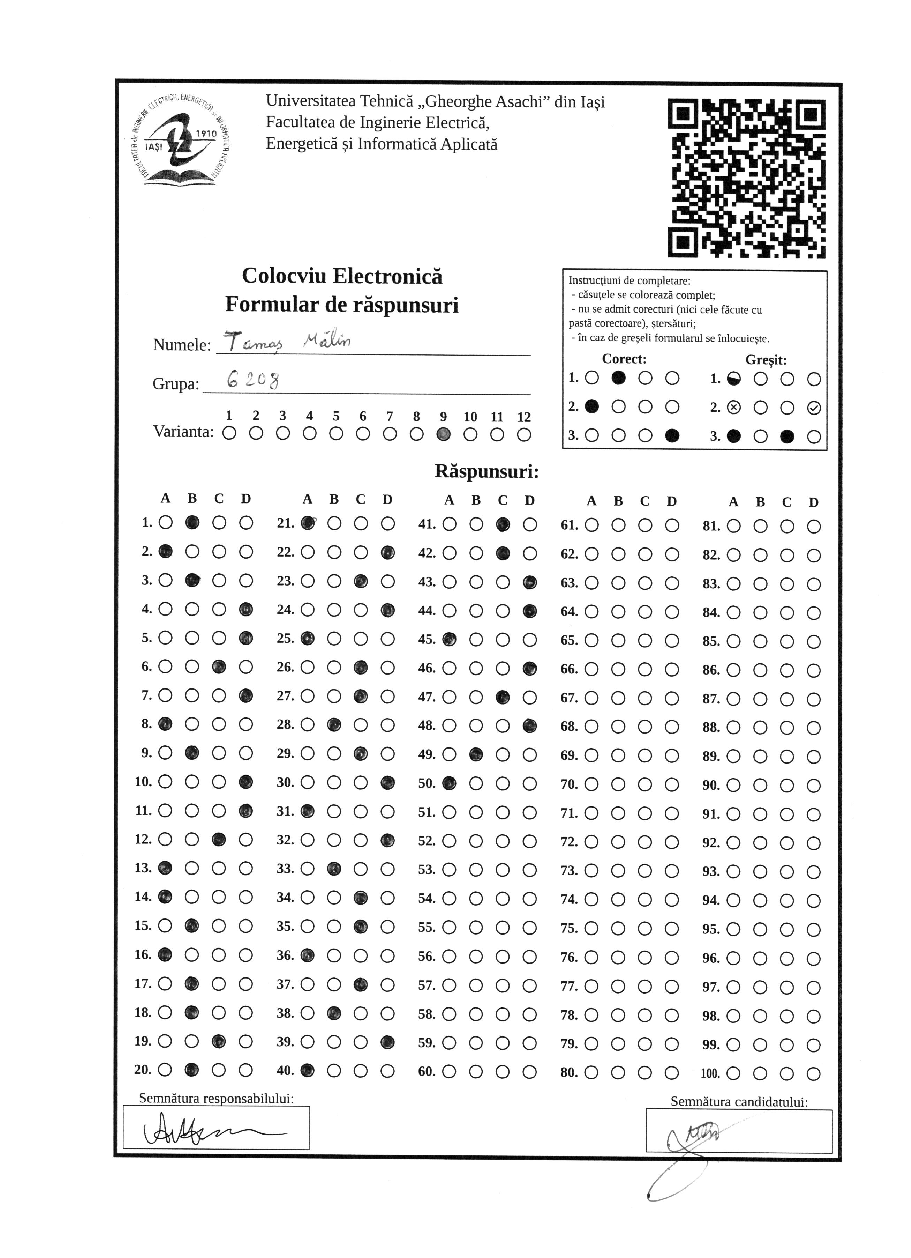

In [112]:
# Load the image
scan_idx = 9
#img_rgb = cv.imread(SCAN_PATH)
#img_rgb = cv.cvtColor(np.array(scans[scan_idx]), cv.COLOR_RGB2BGR)
img_rgb = fitz_to_cv(pdf_scans, pdf_image_refs[scan_idx])

# Convert to gray tones
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

# Decode the QR-code
qrcode = decode(img_gray)[0]
qrdata = qrcode.data.decode('utf-8').split()
department_id = qrdata[0]
course_id = qrdata[1]
exam_date = qrdata[2]
variants_count = int(qrdata[3])
questions_count = int(qrdata[4])
mx = 0
my = 0
for p in qrcode.polygon:
    mx = mx + p.x
    my = my + p.y
    
mx = mx / 4
my = my / 4

height = img_gray.shape[0]
width = img_gray.shape[1]
img_corners = {(0, 0): 1, (width, 0): 0, (0, height): 2, (width, height): 3}
min_dist = m.sqrt(height**2 + width**2)
rotation_count = 0
for k in img_corners:
    dist = m.sqrt((mx-k[0])**2 + (my-k[1])**2)
    if min_dist > dist:
        min_dist = dist
        rotation_count = img_corners[k]

# Rotate the image such that the page is correctly oriented
for c in range(rotation_count):
    img_gray = cv.transpose(img_gray)
    img_gray = cv.flip(img_gray, flipCode=1)

qrcode = decode(img_gray)[0]
qr_vertices = np.zeros((4, 1, 2), dtype=np.int32)
for idx in range(4):
    p = qrcode.polygon[idx]
    qr_vertices[idx][0][0] = p.x
    qr_vertices[idx][0][1] = p.y

plt.figure(figsize=FIGSIZE)
plt.axis("off")
plt.imshow(img_gray, cmap = plt.cm.gray);

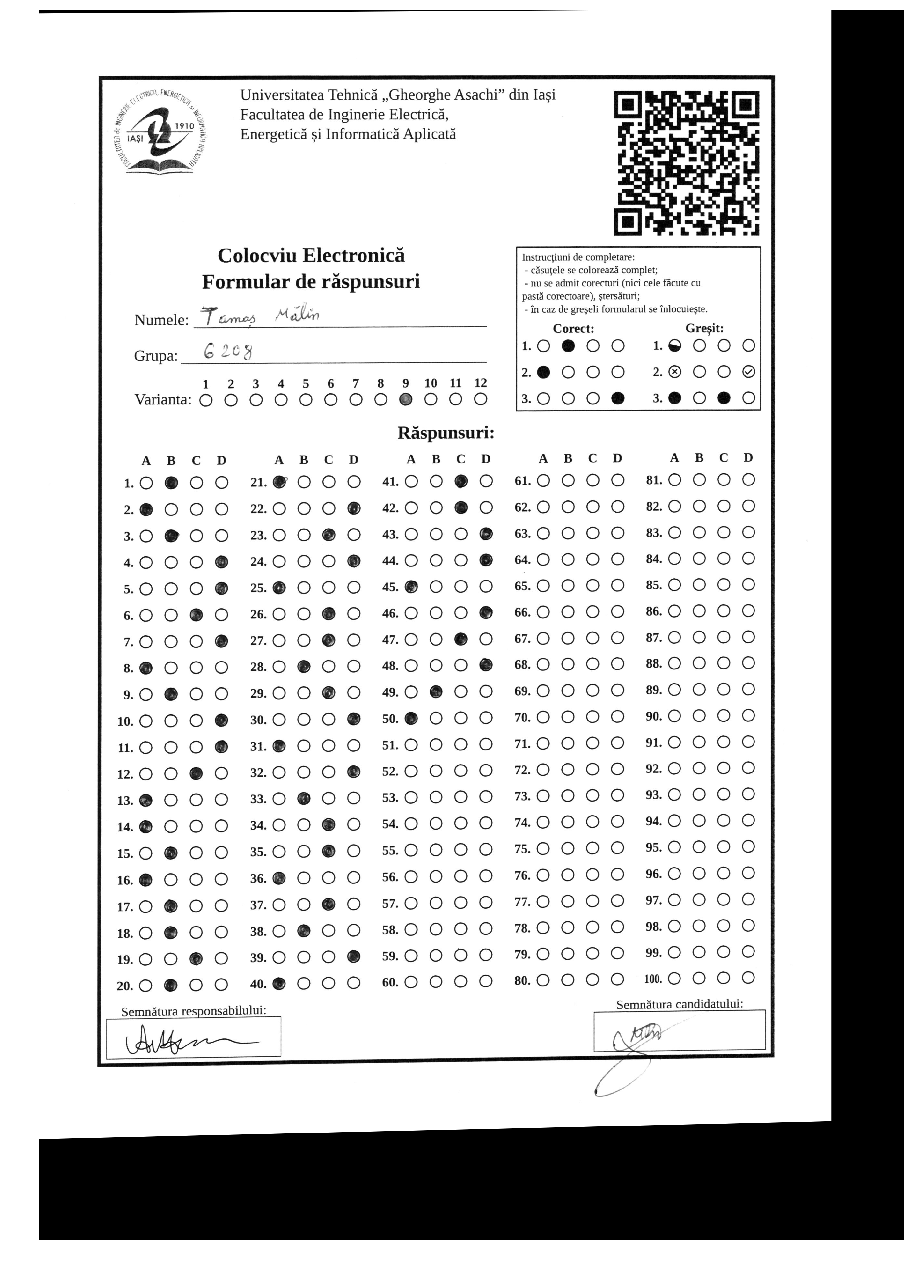

In [113]:
# get template informations from the svg file
page_dims, qr_dims, bounding_rect, answer_bubbles = get_template_rois(TEMPLATE_PATH)

# crop the page to edges, in relation to qr shape
qr_norms = [np.linalg.norm(d) for d in qr_vertices]
qr_vertices = np.roll(qr_vertices, -np.argmin(qr_norms), axis=0)
qr_deltas = qr_vertices - np.roll(qr_vertices, 1, axis=0)
qr_lengths = [int(np.linalg.norm(d)) for d in qr_deltas]
new_qr_width = max(qr_lengths)
new_qr_height = int(qr_dims['height'] * new_qr_width / qr_dims['width'])
qr_x = qr_vertices[0][0][0]
qr_y = qr_vertices[0][0][1]
new_qr_vertices = np.array([
        [qr_x, qr_y],
        [qr_x, qr_y + new_qr_height - 1],
        [qr_x + new_qr_width - 1, qr_y + new_qr_height - 1],
        [qr_x + new_qr_width - 1, qr_y]], dtype = "float32")
resh_qr_vertices = np.float32(np.reshape(qr_vertices, (4, 2)))
# compute the perspective transform matrix and then apply it
M = cv.getPerspectiveTransform(resh_qr_vertices, new_qr_vertices)
dim_max = int(max(img_gray.shape)*1.2)
img_qr_box = cv.warpPerspective(img_gray,
                                M,
                                (int(img_gray.shape[1]*1.1), int(img_gray.shape[0]*1.1)))
marg_lx = bounding_rect['x'] / 3
marg_ly = bounding_rect['y'] / 3
#marg_rx = (page_dims['width'] - (bounding_rect['x'] + bounding_rect['width'])) / 3
#marg_ry = (page_dims['height'] - (bounding_rect['y'] + bounding_rect['height'])) / 3
new_page_xul = int(new_qr_vertices[0][0] - (qr_dims['x'] + marg_lx) * new_qr_width / qr_dims['width'])
if new_page_xul < 0:
    new_page_xul = 0
new_page_yul = int(new_qr_vertices[0][1] - (qr_dims['y'] + marg_ly)* new_qr_height / qr_dims['height'])
if new_page_yul < 0:
    new_page_yul = 0
new_page_xlr = int(new_qr_vertices[0][0] +
                   (page_dims['width'] - qr_dims['x']) * new_qr_width / qr_dims['width'] * 1.2)
if new_page_xlr > img_qr_box.shape[1]:
    new_page_xlr = img_qr_box.shape[1]
new_page_ylr = int(new_qr_vertices[0][1] +
                   (page_dims['height'] - qr_dims['y']) * new_qr_height / qr_dims['height'] * 1.2) 
if new_page_ylr > img_qr_box.shape[0]:
    new_page_ylr = img_qr_box.shape[0]

# crop the image
img_qr_box = img_qr_box[new_page_yul:new_page_ylr, new_page_xul:new_page_xlr]

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_qr_box, cmap = plt.cm.gray);

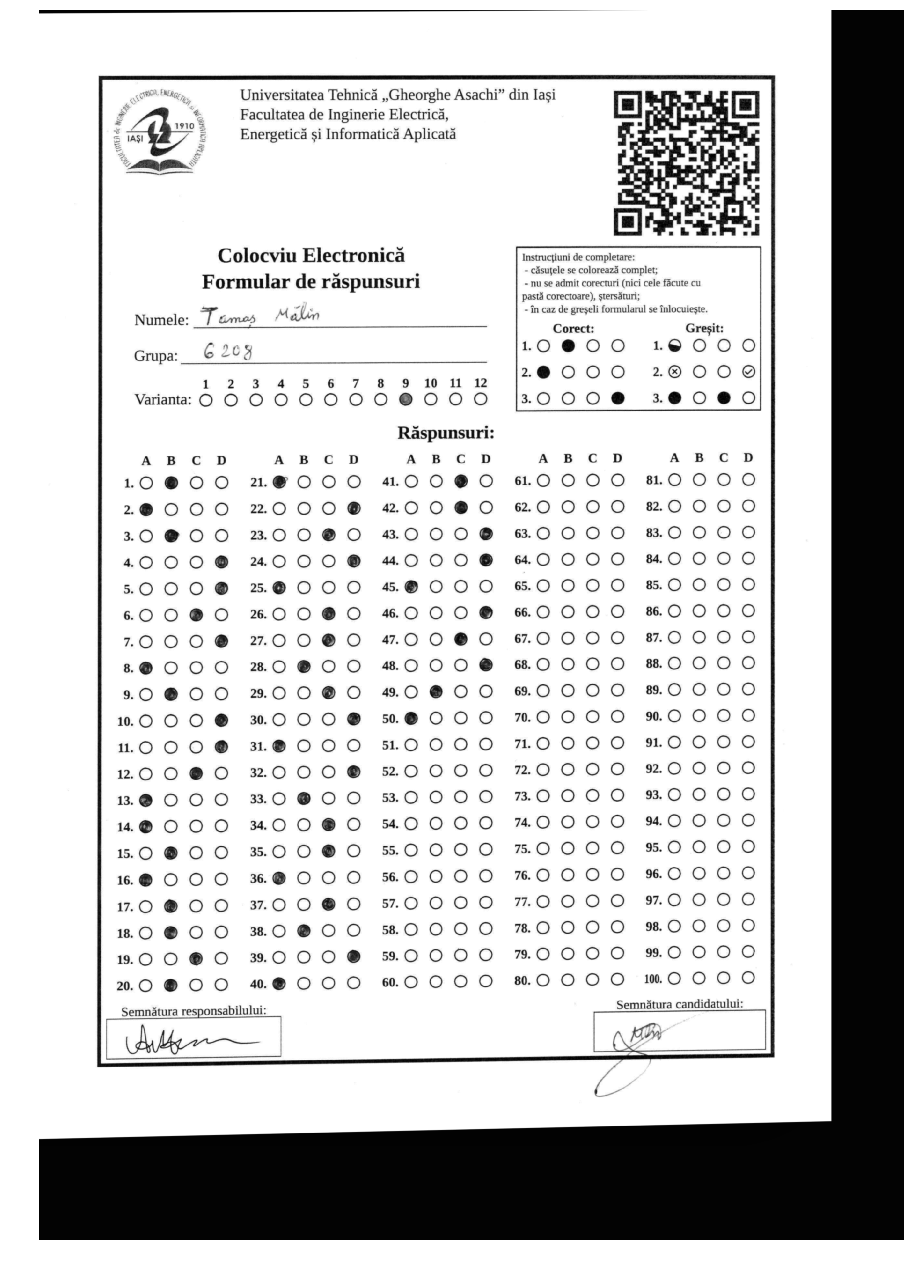

In [120]:
# create a CLAHE object
clahe = cv.createCLAHE(clipLimit=CLAHE_CLIPLIMIT)
# apply CLAHE for better contrast
img_clahe = clahe.apply(img_qr_box)

# apply blur
img_blur = cv.GaussianBlur(img_clahe, (FIRST_BLUR_KSIZE, FIRST_BLUR_KSIZE), 0)

if not SKIP_FIRST_ADAPTIVE_THRESH:
    # apply adaptive thresholding
    img_th = cv.adaptiveThreshold(img_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                  cv.THRESH_BINARY, FIRST_THRESH_BLOCK_SIZE, THRESH_BIAS)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_th if not SKIP_FIRST_ADAPTIVE_THRESH else img_blur, cmap = plt.cm.gray);

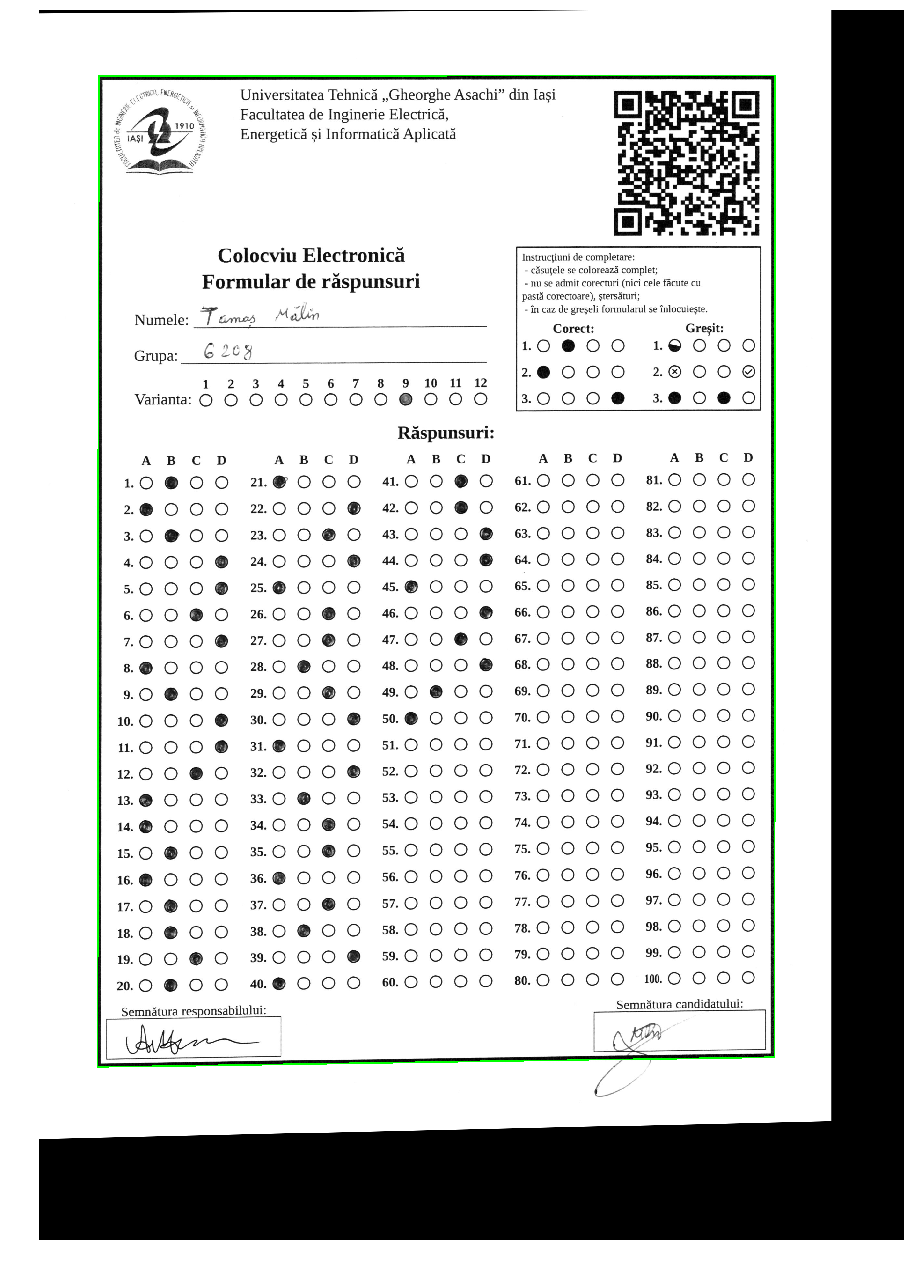

In [121]:
# apply laplace edge detection
img_laplace = cv.Laplacian(img_th if not SKIP_FIRST_ADAPTIVE_THRESH else img_blur, cv.CV_8U, ksize=LAPLACE_KSIZE)

# find contours in the edged image
_, contours, _ = cv.findContours(img_laplace, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

# select the max area contour
contour = max(contours, key = cv.contourArea)
perimeter = cv.arcLength(contour, True)
approx_contour = cv.approxPolyDP(contour, CONTOUR_EPS * perimeter, True)
vertices = cv.convexHull(approx_contour, clockwise=True)
img_result = cv.drawContours(cv.cvtColor(img_qr_box, cv.COLOR_GRAY2BGR), [vertices], 0, (0,255,0), 3)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_result);

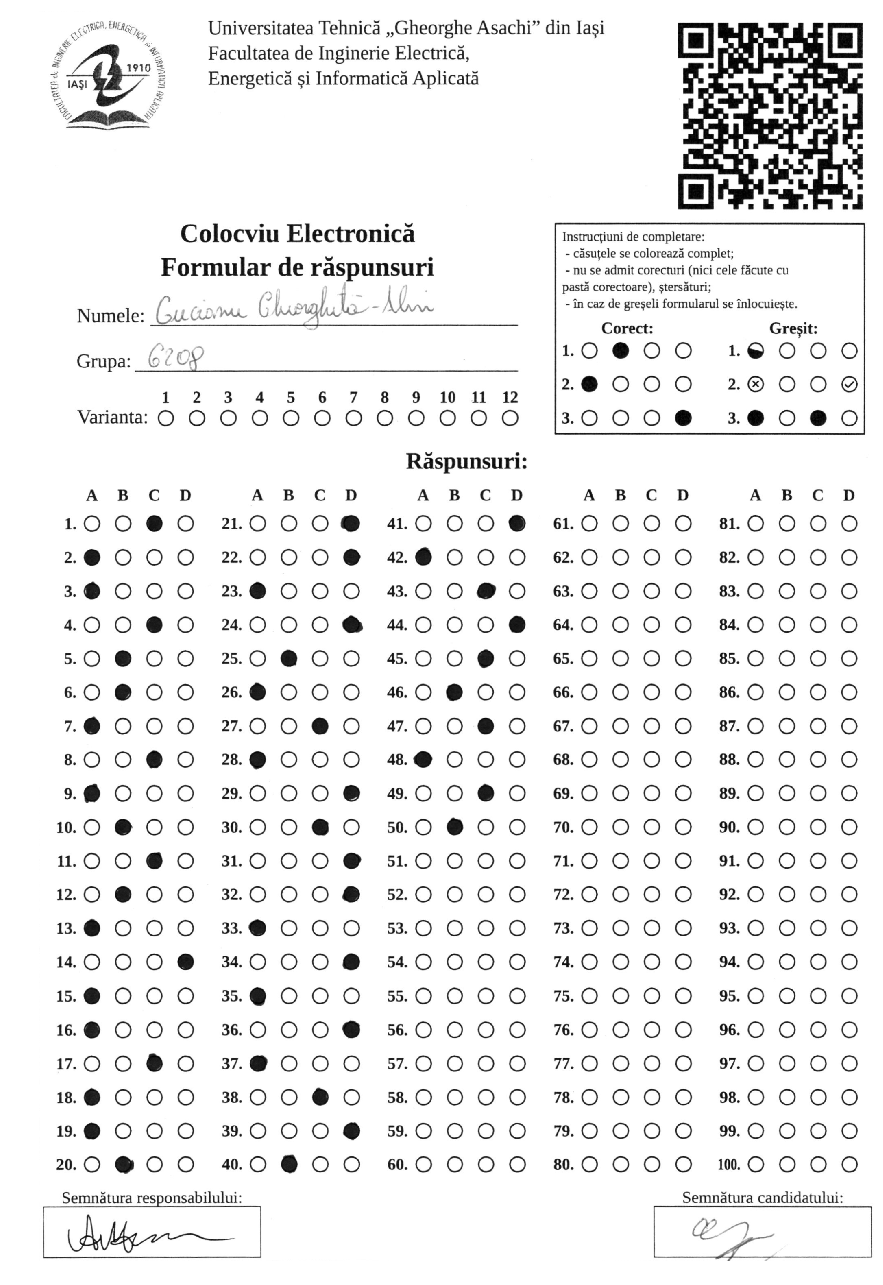

In [106]:
box_frac = bounding_rect['stroke-width'] / bounding_rect['width']
norms = [np.linalg.norm(d) for d in vertices]
vertices = np.roll(vertices, -np.argmin(norms), axis=0)
deltas = vertices - np.roll(vertices, 1, axis=0)
lengths = [int(np.linalg.norm(d)) for d in deltas]
dim = max(lengths)
new_height = dim
new_width = dim * int(bounding_rect['width'] - bounding_rect['stroke-width']) // \
            int(bounding_rect['height'] - bounding_rect['stroke-width'])
new_vertices = np.array([
        [0, 0],
        [0, new_height - 1],
        [new_width - 1, new_height - 1],
        [new_width - 1, 0]], dtype = "float32")
vertices = np.float32(np.reshape(vertices, (4, 2)))
# compute the perspective transform matrix and then apply it
M = cv.getPerspectiveTransform(vertices, new_vertices)
img_box = cv.warpPerspective(img_qr_box, M, (new_width, new_height))
crop_width = int(np.round(img_box.shape[0] * box_frac))

translate_tm = np.identity(3)
translate_tm[0, 2] = -bounding_rect['x']
translate_tm[1, 2] = -bounding_rect['y']
scale_tm = np.identity(3)
scale_factor = img_box.shape[1] / (bounding_rect['width'] + bounding_rect['stroke-width'])
scale_tm[0, 0] = scale_factor
scale_tm[1, 1] = scale_factor
map_tm = scale_tm @ translate_tm

# map bubbles template coordinates to image coordinates
initial_r = np.array([answer_bubbles[0]['r'], 0, 1.0], ndmin=2).T
mapped_r = np.ceil(scale_tm @ initial_r)
circle_r = mapped_r[0][0]
circle_area = m.pi * circle_r**2
circle_peri = 2 * m.pi * circle_r
for idx in range(len(answer_bubbles)):
    initial_coords = np.array([answer_bubbles[idx]['cx'], answer_bubbles[idx]['cy'], 1.0], ndmin=2).T
    mapped_coords = map_tm  @ initial_coords
    answer_bubbles[idx]['cx'] = int(mapped_coords[0,0])
    answer_bubbles[idx]['cy'] = int(mapped_coords[1,0])
    answer_bubbles[idx]['r'] = circle_r
    
# crop the margins
img_box = img_box[crop_width:img_box.shape[0]-crop_width, crop_width:img_box.shape[1]-crop_width]

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box, cmap = plt.cm.gray);

In [68]:
# create a CLAHE object
clahe_box = cv.createCLAHE(clipLimit=CLAHE_CLIPLIMIT)
# apply CLAHE for better contrast
img_box_clahe = clahe.apply(img_box)

# apply blur
img_box_blur = cv.GaussianBlur(img_box_clahe, (BLUR_KSIZE, BLUR_KSIZE), 0)

if not SKIP_SECOND_ADAPTIVE_THRESH:
    # apply adaptive thresholding
    img_box_th = cv.adaptiveThreshold(img_box_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv.THRESH_BINARY, THRESH_BLOCK_SIZE, 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_th if not SKIP_SECOND_ADAPTIVE_THRESH else img_box_blur, cmap = plt.cm.gray);

In [69]:
# apply canny edge detection
img_box_canny = cv.Canny(img_box_th if not SKIP_SECOND_ADAPTIVE_THRESH else img_box_blur, 75, 200)

# find contours in the boxed image
_, box_contours, _ = cv.findContours(img_box_canny, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)


img_box_result = cv.drawContours(cv.cvtColor(img_box, cv.COLOR_GRAY2BGR), box_contours, -1, (0,255,255), 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);

In [70]:
by_compactness_contours = []
for c in box_contours:
    moments = cv.moments(c)
    if moments['mu20']+moments['mu02'] != 0:
        compactness = moments['m00']**2/(2*m.pi*(moments['mu20']+moments['mu02']))
        if abs(compactness - 1) < COMPACTNESS_EPS:
            by_compactness_contours.append(c)

img_box_result = cv.drawContours(cv.cvtColor(img_box, cv.COLOR_GRAY2BGR),
                                 by_compactness_contours, -1, (0,255,255), 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);

In [71]:
by_area_contours = [c for c in by_compactness_contours \
                    if abs((circle_area - cv.contourArea(c)) / circle_area) <= AREA_EPS]
img_box_result = cv.drawContours(cv.cvtColor(img_box, cv.COLOR_GRAY2BGR),
                                 by_area_contours, -1, (0,255,255), 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);

In [72]:
# filter contours by selecting only the contours in expected locations
# (i.e. by closeness to the expected locations)
# if several contours are close to the expected locations,
# only select the largest ones

for c in by_area_contours:
    moments = cv.moments(c)
    mx = moments['m10'] / moments['m00']
    my = moments['m01'] / moments['m00']
    min_dist = circle_r * (1 + CLOSENESS_EPS)
    bubble_pair = 0
    for bubble_idx in range(len(answer_bubbles)):
        bubble = answer_bubbles[bubble_idx]
        cx = bubble['cx']
        cy = bubble['cy']
        if min_dist > m.sqrt((cx - mx)**2 + (cy - my)**2):
            min_dist = m.sqrt((cx - mx)**2 + (cy - my)**2)
            bubble_pair = bubble_idx
    if abs(min_dist - circle_r) / circle_r < CLOSENESS_EPS:
        if 'contours' in answer_bubbles[bubble_pair]:
            answer_bubbles[bubble_pair]['contours'].append(c)
        else:
            answer_bubbles[bubble_pair]['contours'] = [c]

for bubble in answer_bubbles:
    if 'contours' in bubble:
        max_contour = max(bubble['contours'], key = cv.contourArea)
        moments = cv.moments(max_contour)
        mx = int(moments['m10'] / moments['m00'])
        my = int(moments['m01'] / moments['m00'])
        bubble['mx'] = mx
        bubble['my'] = my
        bubble['optimal_contour'] = max_contour

img_box_result = cv.cvtColor(img_box, cv.COLOR_GRAY2BGR)

# draw bubbles
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        cv.circle(img_box_result,
              (bubble['mx'], bubble['my']), int(circle_r), (0,255,255), 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);

In [73]:
# classify bubbles into 'filled' and 'not filled'
mask = np.zeros((*img_box_th.shape,), np.uint8)
bubble_means = []
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        mask[...] = 0
        cv.circle(mask, (bubble['mx'], bubble['my']), int(circle_r), 255, -1)
        bubble['mean'] = cv.mean(img_box_th, mask)[0]
        bubble_means.append(bubble['mean'])
filled_threshold = np.mean(bubble_means) * 0.9
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        bubble['is_filled'] = bubble['mean'] < filled_threshold

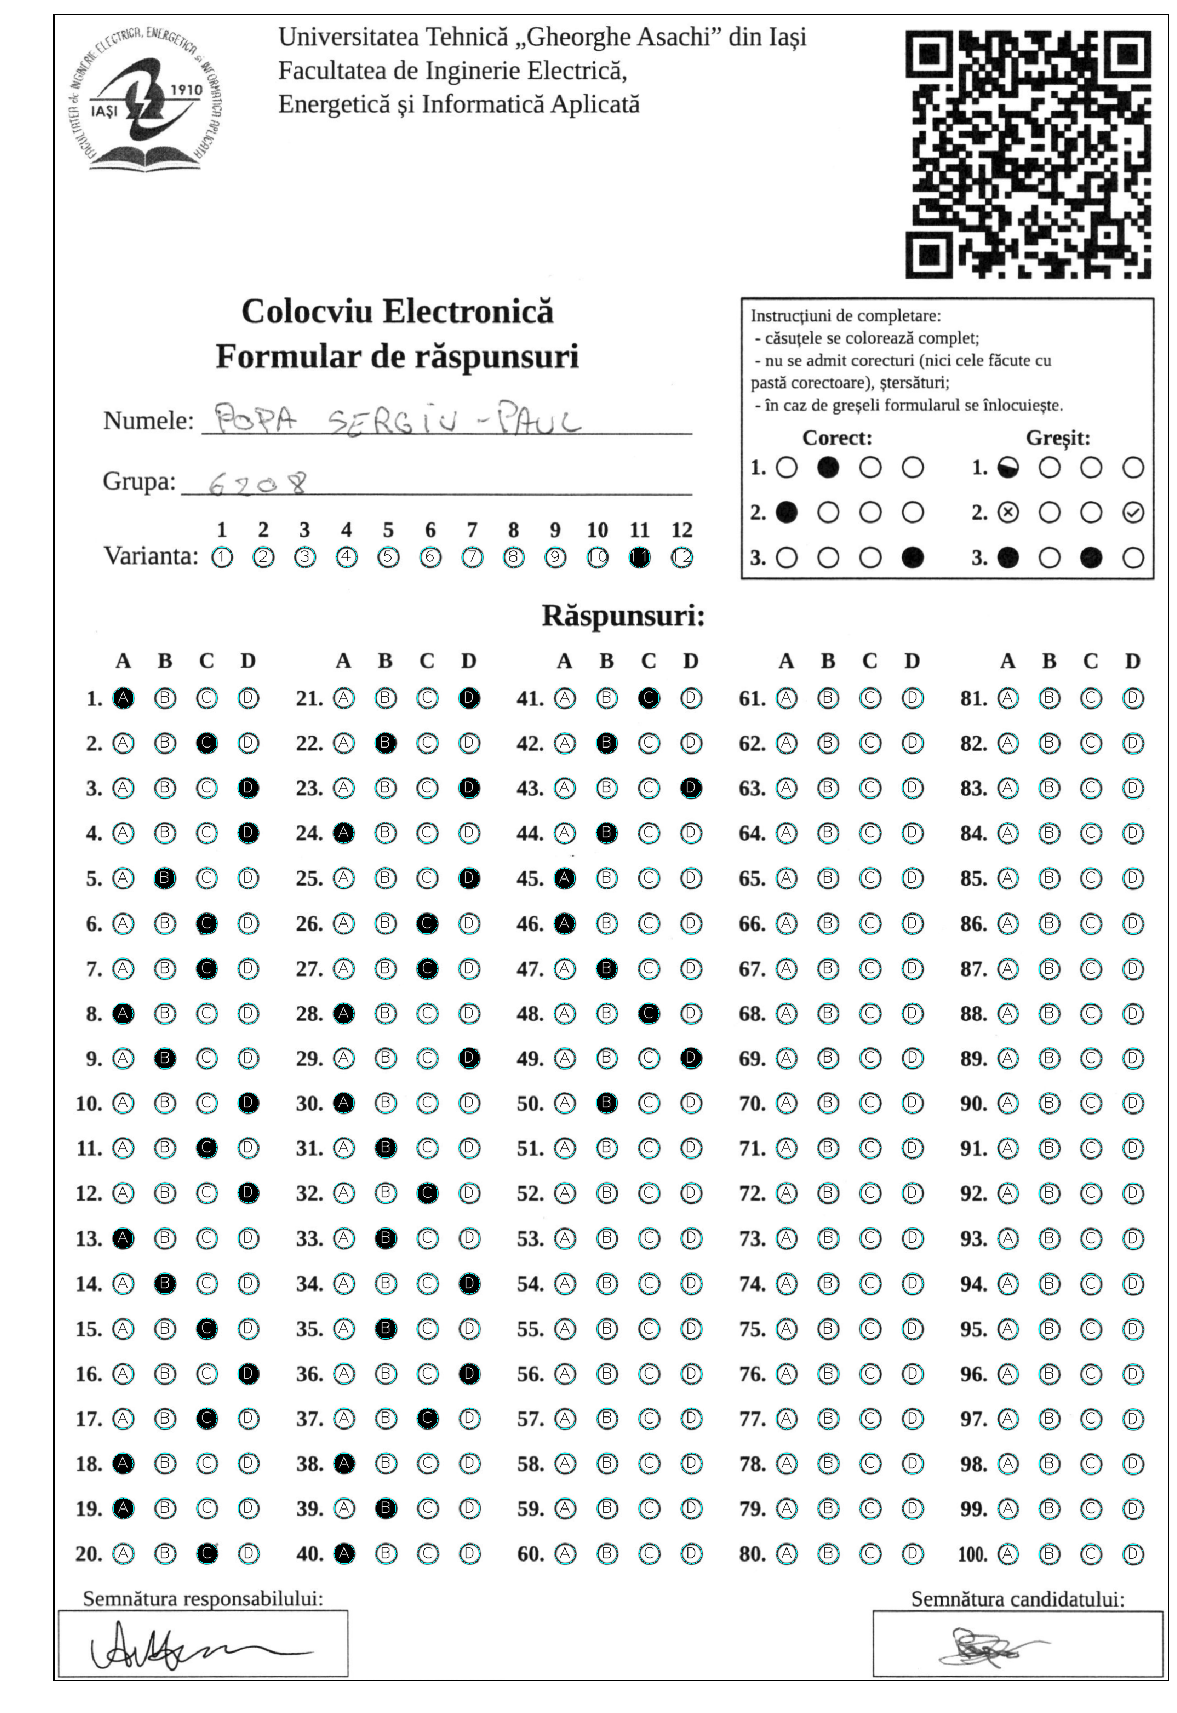

In [74]:
# draw bubbles according to the previous classification
font = cv.FONT_HERSHEY_PLAIN
font_size = 0.7 * img_box.shape[0] / 1000.0
bubble_color = (0, 255, 255)
#img_box_result = 255 * np.ones((*img_box_result.shape,), np.uint8)
img_box_result = cv.cvtColor(img_box, cv.COLOR_GRAY2BGR)
cv.rectangle(img_box_result, (0, 0), (img_box_result.shape[1], img_box_result.shape[0]), (0,0,0), 3)

for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        if bubble['is_filled']:
            cv.circle(img_box_result,
                  (bubble['mx'], bubble['my']), int(circle_r), (0,0,0), -1)
        cv.circle(img_box_result,
              (bubble['mx'], bubble['my']), int(circle_r), bubble_color, 1)
        id_parts = bubble['id'].split('-')
        if len(id_parts) > 1:
            text = id_parts[1]
        else:
            text = id_parts[0]
        text = text.upper()
        # get boundary of this text
        textsize = cv.getTextSize(text, font, font_size, 1)
        # get coords based on boundary
        textX = bubble['mx'] - textsize[0][0] // 2
        textY = bubble['my'] + textsize[0][1] // 2
        cv.putText(img_box_result, text,
                   (textX, textY), 
                   font, font_size,
                   (255,255,255) if bubble['is_filled'] else (0,0,0), 1, cv.LINE_AA)

plt.figure(figsize=FIGSIZE)
plt.axis("off")
plt.imshow(img_box_result);

In [75]:
# find all answers
answers = {}
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        id, pos = bubble['id'].split('-')
        if id in answers:
            answers[id][pos] = bubble['is_filled']
        else:
            answers[id] = {pos: bubble['is_filled']}

# select only valid answers
valid_answers = {}
for key in answers:
    try:
        q = int(key)
        if (q <= questions_count and len(answers[key]) == 4 and
            list(answers[key].values()).count(True) == 1):
            valid_answers[key] = answers[key]
    except:
        pass

# get variant number
variant = 0
if ('v' in answers and len(answers['v']) ==  variants_count and 
    list(answers['v'].values()).count(True) == 1):
    variant = int(list(answers['v'].keys())[list(answers['v'].values()).index(True)])
if variant > 0:
    print("Varianta: {:2d}".format(variant))
else:
    print("Varianta necunoscuta!")
for q in sorted(valid_answers, key = lambda x: int(x)):
    ans = list(valid_answers[q].keys())[list(valid_answers[q].values()).index(True)]
    print("{:3d} -> {:s}".format(int(q), ans.upper()))

Varianta: 11
  1 -> A
  2 -> C
  3 -> D
  4 -> D
  5 -> B
  6 -> C
  7 -> C
  8 -> A
  9 -> B
 10 -> D
 11 -> C
 12 -> D
 13 -> A
 14 -> B
 15 -> C
 16 -> D
 17 -> C
 18 -> A
 19 -> A
 20 -> C
 21 -> D
 22 -> B
 23 -> D
 24 -> A
 25 -> D
 26 -> C
 27 -> C
 28 -> A
 29 -> D
 30 -> A
 31 -> B
 32 -> C
 33 -> B
 34 -> D
 35 -> B
 36 -> D
 37 -> C
 38 -> A
 39 -> B
 40 -> A
 41 -> C
 42 -> B
 43 -> D
 44 -> B
 45 -> A
 46 -> A
 47 -> B
 48 -> C
 49 -> D
 50 -> B
